Transfer learning with backbone EfficientNetV2B0 on full dataset 1 with target class augmentation 1:5 to find ways to improve feature extraction.

EfficientNet. Feature extraction on full dataset 1.

In [ ]:
import os
import gdown
import shutil
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.utils import save_img, img_to_array, array_to_img, load_img, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
IS_COLAB = "google.colab" in str(get_ipython())

if IS_COLAB:
    small_data_dir = pathlib.Path("/content/content/small_subset")
else:
    # import os
    small_data_dir = pathlib.Path(os.getcwd()) / "Source/content/small_subset"

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: syurt (syurt-institution) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project='melanoma_classification', settings=wandb.Settings(code_dir=None))
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
os.environ["WANDB_MODE"] = "dryrun"
os.environ["WANDB_DIR"] = "/dev/null"
os.environ["WANDB_DATA_DIR"] = "/dev/null"
os.environ["WANDB_CONFIG_DIR"] = "/dev/null"

In [ ]:
def show_dirs_len(path):
  for root, dirs, _ in os.walk(path):
    print(f"{os.path.relpath(root, path)}: {len(os.listdir(root))}")

## Формування робочого датасету

Завантаження джерела

In [ ]:
# https://drive.google.com/file/d/1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee/view?usp=sharing
file_id = "1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2020_supplemented.zip"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee
From (redirected): https://drive.google.com/uc?id=1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee&confirm=t&uuid=dc3233a9-0741-48d2-8d01-9d3d9c1a7af0
To: /content/2020_supplemented.zip
100%|██████████| 1.59G/1.59G [00:29<00:00, 53.1MB/s]


'2020_supplemented.zip'

In [ ]:
!unzip -q 2020_supplemented.zip

In [ ]:
show_dirs_len(pathlib.Path("/content/2020_supplemented"))

.: 2
test: 2
test/melanoma: 1587
test/other: 10638
train: 2
train/melanoma: 5093
train/other: 32112


In [ ]:
# shutil.rmtree("/content/2020_supplemented")
# shutil.rmtree("/content/vignette")

In [ ]:
data_dir = pathlib.Path("/content/2020_supplemented")

Завантажити зображення з набору 2019 року негативного класу з темним фоном та додати частину до валідаційного набору.

In [ ]:
# https://drive.google.com/file/d/11VpzypsPua9QzonH0llk4NuZJnt_vsms/view?usp=sharing
file_id = "11VpzypsPua9QzonH0llk4NuZJnt_vsms"
url = f"https://drive.google.com/uc?id={file_id}"
output = "vignette.zip"

gdown.download(url, output, quiet=False)
!unzip -q vignette.zip

Downloading...
From (original): https://drive.google.com/uc?id=11VpzypsPua9QzonH0llk4NuZJnt_vsms
From (redirected): https://drive.google.com/uc?id=11VpzypsPua9QzonH0llk4NuZJnt_vsms&confirm=t&uuid=ec670dbe-30de-4f9c-aa4c-509a07a8c20c
To: /content/vignette.zip
100%|██████████| 45.3M/45.3M [00:00<00:00, 59.9MB/s]


Функції для виділення з тренувального набору валідаційного, створення підвибірки датасету потрібного розміру.

In [ ]:
def make_sructured_subset(rate, source_path, dest_path, my_seed, copy=True):

  """create folder the same structure as source
     with of content files"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    relative_path = os.path.relpath(root, source_path)
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
def make_balanced_sructured_subset(source_path, dest_path, my_seed, rates_per_class, copy=True):

  """create folder the same structure as source
     with part of content files, picked using different rate for selected folder:
      rate*k"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    relative_path = os.path.relpath(root, source_path)
    class_name = os.path.basename(relative_path)
    if class_name in rates_per_class:
       rate = rates_per_class[class_name]
    else:
      rate = 0.2
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
def make_custom_sructured_subset(source_path, dest_path, my_seed, rates_per_ds, copy=True):

  """create folder the same structure as source
     with % of source folder files, randomly picked
     using different rate for each ds"""
  np.random.seed(my_seed)

  for root, dirs, files in os.walk(source_path):
    relative_path = os.path.relpath(root, source_path)
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    files = sorted(files)
    if files:
      for ds in rates_per_ds.keys():
        if ds in new_folder.split(os.sep):
          rate = rates_per_ds[ds]
          break
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
# select in validation directory equal size of classes
val_dir = data_dir / "validation"
train_dir = data_dir / "train"
num_melanoma = len(os.listdir(os.path.join(train_dir, "melanoma")))
num_other = len(os.listdir(os.path.join(train_dir, "other")))
k = num_melanoma/num_other if num_other > 0 else 1
print(k)
rates_per_class = {
    "melanoma": 0.2,
    "other": 0.2*k
}
make_balanced_sructured_subset(train_dir, val_dir, 10, rates_per_class, copy=False)

0.15860114598903838


In [ ]:
np.random.seed(42)
src_path =  pathlib.Path("/content/vignette")
dest_path = pathlib.Path("/content/2020_supplemented/validation/other")
shuffled_vignette_files = np.random.permutation(os.listdir(src_path))
for image in shuffled_vignette_files[:100]:
  shutil.copyfile(src_path / image, dest_path / image)

In [ ]:
show_dirs_len(data_dir)

.: 3
validation: 2
validation/melanoma: 1018
validation/other: 1118
test: 2
test/melanoma: 1587
test/other: 10638
train: 2
train/melanoma: 4075
train/other: 31094


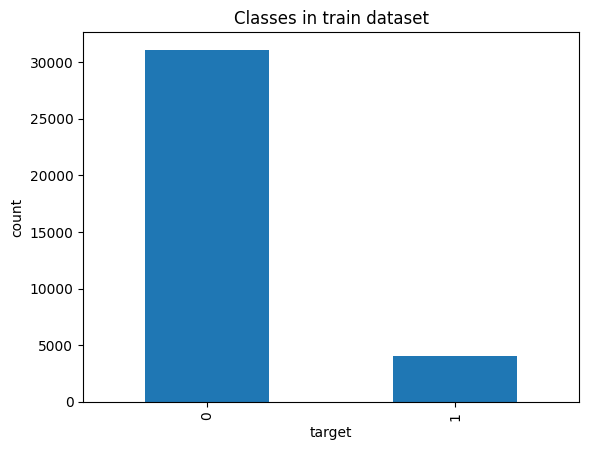

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train dataset')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Аугментація цільового класу для збалансування набору

In [ ]:
def augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=None, add_func=None):
  aug_images_set =[]
  img = load_img(img_path) #завантажує зображення як PIL
  img_arr = img_to_array(img) #конвертує у NumPy
  img_arr = np.expand_dims(img_arr, axis=0)  # додати розмірність - batch
  for i in range(num_aug):
    augmented_img_arr = data_augmentation(img_arr, training=True)
    # augmented_img = keras.utils.array_to_img(augmented_img_arr[0])
    augmented_img = array_to_img(augmented_img_arr[0])   #first in batch
    if add_func is not None:
      augmented_img = add_func(augmented_img)
    aug_images_set.append(augmented_img)
    if save:
      os.makedirs(output_dir, exist_ok=True)
      img_name = os.path.basename(img_path)
      output_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i}.jpg")
      save_img(output_path, augmented_img)
  return aug_images_set

def run_augmentation(data_augmentation, input_dir, output_dir, num_aug, add_func=None):
  for img_name in os.listdir(input_dir):
    if img_name.endswith((".png", ".jpg", ".jpeg")):
      img_path = os.path.join(input_dir, img_name)
      augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=output_dir, add_func=add_func)

def run_selective_augmentation(data_augmentation, input_dir, output_dir, num_aug, ratio=0.3, my_seed=42, add_func=None):
  """augmentation of subset"""
  np.random.seed(my_seed)
  images = os.listdir(input_dir)
  images_to_augm = np.random.choice(images, int(len(images)*ratio), replace=False)
  for img_name in images_to_augm:
    if img_name.endswith((".png", ".jpg", ".jpeg")):
      img_path = os.path.join(input_dir, img_name)
      augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=output_dir, add_func=add_func)

In [ ]:
def add_files(source_dir, dest_dir):
  os.makedirs(dest_dir, exist_ok=True)
  for file_name in os.listdir(source_dir):
    source_file = os.path.join(source_dir, file_name)
    if os.path.isfile(source_file):
      destination_file = os.path.join(dest_dir, file_name)
      shutil.copyfile(source_file, destination_file)

In [ ]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip(mode="horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomZoom(0.3),
      layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode="nearest"),
      # layers.MixUp(alpha=0.2),
      layers.RandomColorJitter(
          value_range=(0, 255),
          brightness_factor=0.1,
          contrast_factor=0.1,
          saturation_factor=(0.46, 0.54),
          hue_factor=0.05)
    ]
)

In [ ]:
# shutil.rmtree("/content/augmented")

In [ ]:
input_dir = pathlib.Path("/content/2020_supplemented/train/melanoma")
output_dir = pathlib.Path("/content/augmented")

Аугментація зображень з тренувального набору (вибірка) для класу "меланома".

In [ ]:
np.random.seed(42)
augm_example = np.random.choice(os.listdir(input_dir), 1)[0]
augm_example_path = os.path.join(input_dir, augm_example)
augm_example_set = augment_and_save(augm_example_path, data_augmentation, 5, save=False)
augm_example_set = [Image.open(augm_example_path)] + augm_example_set

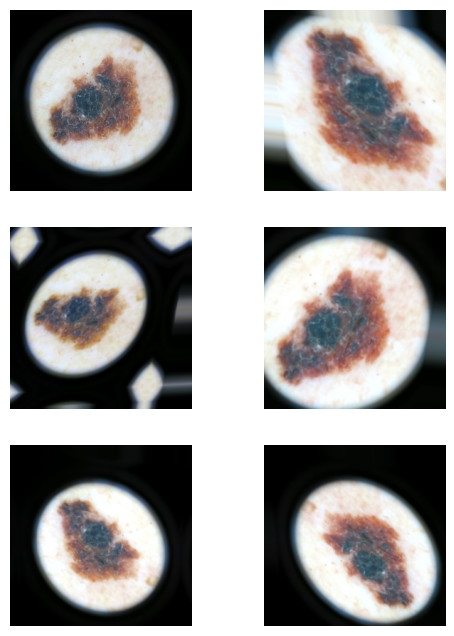

In [ ]:
plt.figure(figsize=(6, 8))
for i, image in enumerate(augm_example_set):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(img_to_array(image).astype("uint8"))
  plt.axis("off")

In [ ]:
run_augmentation(data_augmentation, input_dir, output_dir, 4)

In [ ]:
show_dirs_len(output_dir)

.: 16300


In [ ]:
# зберегти за потреби аугментовані зображення
!zip -q -r 2020_train_melanoma_augmented_full.zip . -i /augmented/*
from google.colab import files
files.download("2020_train_melanoma_augmented_full.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# зберегти за потреби вибірку без аугментації
!zip -q -r full_ds_1920_no_augm.zip /content/2020_supplemented/
from google.colab import files
files.download("full_ds_1920_no_augm.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# додати аугментовані файли у вибірку
add_files(output_dir, input_dir)

In [ ]:
show_dirs_len(input_dir)

.: 20375


In [ ]:
show_dirs_len(data_dir)

.: 3
validation: 2
validation/melanoma: 1018
validation/other: 1118
test: 2
test/melanoma: 1587
test/other: 10638
train: 2
train/melanoma: 20375
train/other: 31094


In [ ]:
# зберегти вибірку з аугментацією цільового класу
!zip -q -r full_ds_1920_with_augm.zip /content/2020_supplemented/
from google.colab import files
files.download("full_ds_1920_with_augm.zip")

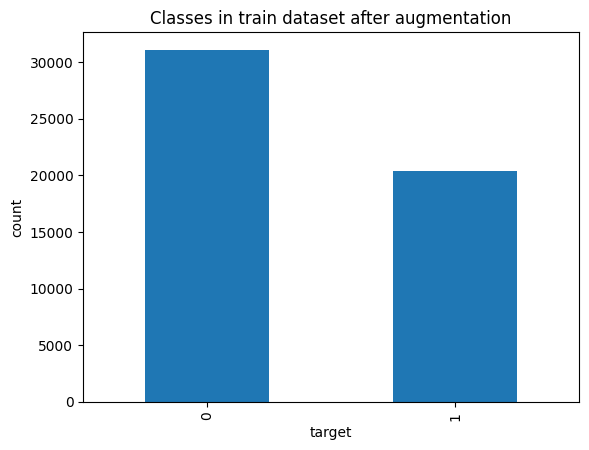

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train dataset after augmentation')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Датасет для доповнення аугментації

In [ ]:
# весь датасет без аугментації з виділеним валідаційним набором
# https://drive.google.com/file/d/1D23biRbVrOBo_W4PztI1CtWZkedAh8LU/view?usp=sharing
file_id = "1D23biRbVrOBo_W4PztI1CtWZkedAh8LU"
url = f"https://drive.google.com/uc?id={file_id}"
output = "full_ds_1920_no_augm.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1D23biRbVrOBo_W4PztI1CtWZkedAh8LU
From (redirected): https://drive.google.com/uc?id=1D23biRbVrOBo_W4PztI1CtWZkedAh8LU&confirm=t&uuid=a3b92ec8-d49a-4968-a80c-2db7815b83f3
To: /content/full_ds_1920_no_augm.zip
100%|██████████| 1.59G/1.59G [00:22<00:00, 71.6MB/s]


'full_ds_1920_no_augm.zip'

In [ ]:
!unzip -q full_ds_1920_no_augm.zip

In [ ]:
# додати агресивнішу аугментацію
data_augmentation2 = keras.Sequential(
    [ layers.RandomFlip(mode="horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomZoom(0.8),
      layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode="nearest"),
      # layers.MixUp(alpha=0.2),
      layers.RandomColorJitter(
          value_range=(0, 255),
          brightness_factor=0.3,
          contrast_factor=0.2,
          saturation_factor=(0.3, 0.6),
          hue_factor=0.2)
    ]
)

In [ ]:
input_dir = pathlib.Path("/content/content/2020_supplemented/train/melanoma")
output_dir = pathlib.Path("/content/augmented")

In [ ]:
np.random.seed(22)
augm_example = np.random.choice(os.listdir(input_dir), 1)[0]
augm_example_path = os.path.join(input_dir, augm_example)
augm_example_set = augment_and_save(augm_example_path, data_augmentation, 5, save=False)
augm_example_set = [Image.open(augm_example_path)] + augm_example_set

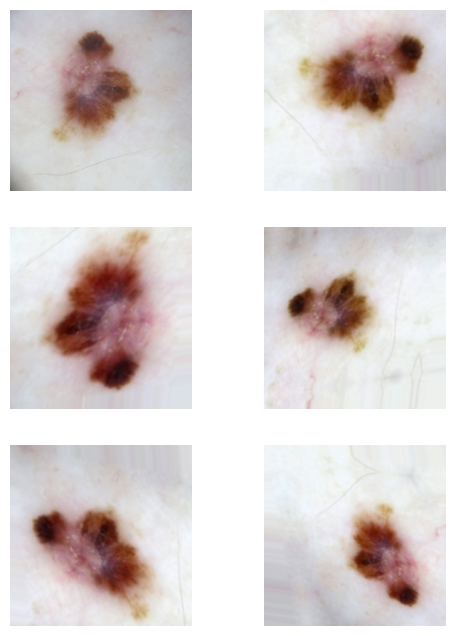

In [ ]:
plt.figure(figsize=(6, 8))
for i, image in enumerate(augm_example_set):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(img_to_array(image).astype("uint8"))
  plt.axis("off")

In [ ]:
run_augmentation(data_augmentation, input_dir, output_dir, 1)

In [ ]:
# зберегти аугментовані зображення
!zip -q -r 2020_train_melanoma_augmented_add.zip . -i /augmented/*
from google.colab import files
files.download("2020_train_melanoma_augmented_add.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Завантаження даних для навчання

In [ ]:
# весь датасет з аугментацією 1:4
# https://drive.google.com/file/d/1Jr-SkgzsDrLh_e_kgsa39bQ22w9aNWr7/view?usp=sharing
file_id = "1Jr-SkgzsDrLh_e_kgsa39bQ22w9aNWr7"
url = f"https://drive.google.com/uc?id={file_id}"
output = "full_ds_1920_with_augm.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Jr-SkgzsDrLh_e_kgsa39bQ22w9aNWr7
From (redirected): https://drive.google.com/uc?id=1Jr-SkgzsDrLh_e_kgsa39bQ22w9aNWr7&confirm=t&uuid=2c4f21b6-f023-44f1-aff9-04c64c473246
To: /content/full_ds_1920_with_augm.zip
100%|██████████| 1.71G/1.71G [00:40<00:00, 42.4MB/s]


'full_ds_1920_with_augm.zip'

In [ ]:
!unzip -q full_ds_1920_with_augm.zip

In [ ]:
data_dir = pathlib.Path("/content/content/2020_supplemented")
show_dirs_len(data_dir)

.: 3
train: 2
train/melanoma: 20375
train/other: 31094
validation: 2
validation/melanoma: 1018
validation/other: 1118
test: 2
test/melanoma: 1587
test/other: 10638


### Завантажити доповнення аугментації

In [ ]:
# додаткові дані з аугментацією
# https://drive.google.com/file/d/1Y1Ugr91X3zBz3gPyRm1e8iw74JcJidQU/view?usp=sharing
file_id = "1Y1Ugr91X3zBz3gPyRm1e8iw74JcJidQU"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2020_train_melanoma_augmented_add.zip"

gdown.download(url, output, quiet=False)
!unzip -q 2020_train_melanoma_augmented_add.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Y1Ugr91X3zBz3gPyRm1e8iw74JcJidQU
From (redirected): https://drive.google.com/uc?id=1Y1Ugr91X3zBz3gPyRm1e8iw74JcJidQU&confirm=t&uuid=61e827ff-b96f-4e31-9cf1-7b76d2c28ca8
To: /content/2020_train_melanoma_augmented_add.zip
100%|██████████| 30.5M/30.5M [00:01<00:00, 24.6MB/s]


In [ ]:
folder_path = pathlib.Path('/content/augmented')
for filename in os.listdir(folder_path):
    old_path = os.path.join(folder_path, filename)
    new_filename = filename[:-5] + "4" + filename[-4:]
    new_path = os.path.join(folder_path, new_filename)
    os.rename(old_path, new_path)


In [ ]:
# додати аугментовані файли у вибірку
source_dir = pathlib.Path('/content/augmented')
dest_dir = pathlib.Path('/content/content/2020_supplemented/train/melanoma')
add_files(source_dir, dest_dir)

In [ ]:
data_dir = pathlib.Path("/content/content/2020_supplemented")
show_dirs_len(data_dir)

.: 3
train: 2
train/other: 31094
train/melanoma: 24450
validation: 2
validation/other: 1118
validation/melanoma: 1018
test: 2
test/other: 10638
test/melanoma: 1587


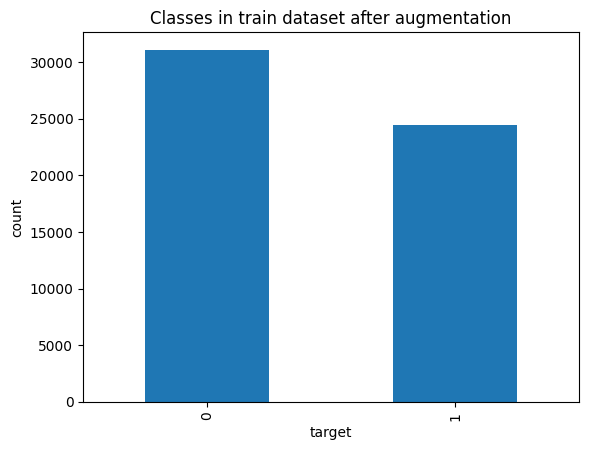

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train dataset after augmentation')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Визначення параметрів, функцій для побудови моделі

In [ ]:
def generate_model_version_name():

  from datetime import datetime

  now = datetime.now()
  month_day = now.strftime("%m-%d")  # Формат: ММ-ДД
  hours = now.strftime("%H")  # Формат: ЧЧ, тільки години
  return month_day + "-" + hours

In [ ]:
# при дисбалансі класів
def binary_class_weights(dataset):
  count_1 = 0
  count_0 = 0
  for items, labels in dataset:
    labels = labels.numpy()
    count_1 += np.sum(labels==1)
    count_0 += np.sum(labels==0)
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return (weight_0, weight_1)

def initial_bias_calc(dataset):
  count_1 = 0
  count_0 = 0
  for items, labels in dataset:
    labels = labels.numpy()
    count_1 += np.sum(labels==1)
    count_0 += np.sum(labels==0)
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return np.log([count_1/count_0])


In [ ]:
# при дисбалансі класів при відомій кількості екземплярів кожного класу
def binary_class_weights_2(count_1, count_0):
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return (weight_0, weight_1)

def initial_bias_calc_2(count_1, count_0):
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return np.log(count_1/count_0)

In [ ]:
# логування
import csv
from tensorflow.keras.callbacks import Callback

# зібрати під час навчання метрики
class MetricsLogger(Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.metrics = None
        # create file on init
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
    # method Callbak class
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # get logs keys
        if self.metrics is None:
          self.metrics = list(logs.keys())
            # add metrics header to csv
          with open(self.filepath, mode='a', newline='') as f:
              writer = csv.writer(f)
              writer.writerow(['epoch'] + self.metrics)
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch] + [logs[m] for m in self.metrics])

In [ ]:
# візуалізація
def plot_scores (df, model_name, metrics_list):
  n = len(metrics_list)
  fig = plt.figure(figsize=(16, int(np.ceil(n/3)*4) ))
  fig.suptitle(f'{model_name}')
  for i, metric in enumerate(metrics_list):
    ax = plt.subplot(int(np.ceil(n/3)), 3, i + 1)
    ax.plot(df.index+1, df[metric], label=metric)
    ax.plot(df.index+1, df["val_" + metric], label="val_" + metric)
    ax.legend(loc='lower right')
    ax.grid(True)
  fig2 = plt.figure(figsize=(8, 6))
  for i, metric in enumerate(metrics_list):
    plt.plot(df.index+1, df[metric], label=metric)
    plt.plot(df.index+1, df["val_" + metric], label="val_" + metric)
  plt.legend(loc='lower right')
  plt.show();

def plot_loss(df, model_name):
  fig = plt.figure(figsize=(8, 6))
  fig.suptitle(f'{model_name + " loss"}')
  plt.plot(df.index+1, df['loss'], label='train loss')
  plt.plot(df.index+1, df["val_loss"], label="validation loss")
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show();

In [ ]:
def plot_confusion_matrix(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["other", "melanoma"])
  disp.plot(cmap=plt.cm.Blues)
  plt.xlabel("Predictions")
  plt.ylabel("Actual")
  plt.title('Confusion matrix')
  plt.show()

In [ ]:
def fbeta_metric(precision, recall, beta=2.0):
  return precision * recall * (1+beta**2)/( (beta**2) * precision + recall)

### tf.Dataset

In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]
VERSION = generate_model_version_name()
LEARNING_RATE = 1e-5

In [ ]:
VERSION

'04-12-10'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

Found 55544 files belonging to 2 classes.
Found 2136 files belonging to 2 classes.
Found 12225 files belonging to 2 classes.


### Візуалізація датасету

In [ ]:
class_names = train_ds.class_names
print(class_names)

['other', 'melanoma']


In [ ]:
print(train_ds)
print(val_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


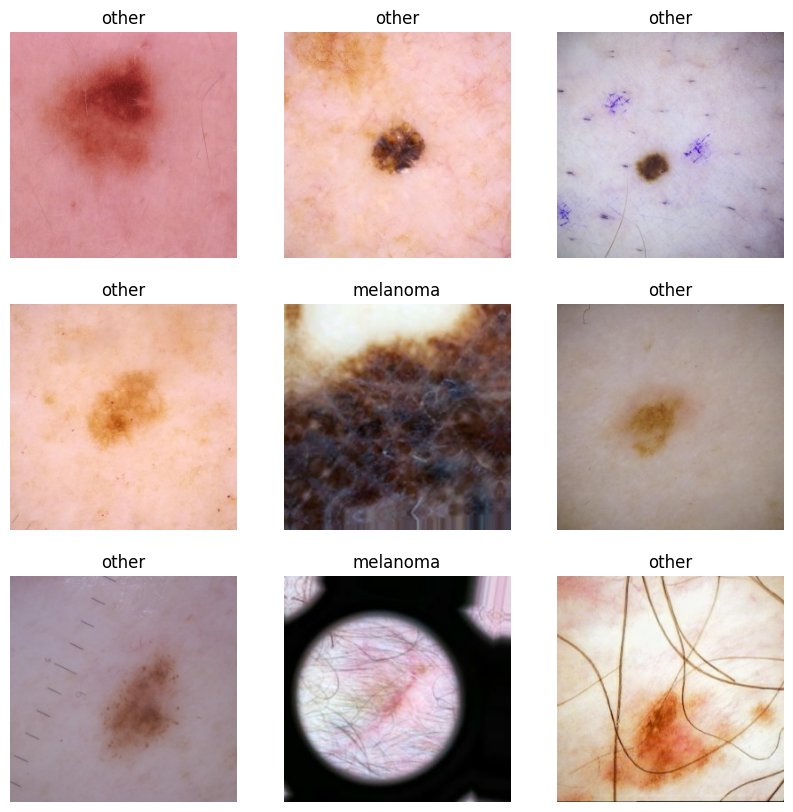

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Створення моделі, передобробка датасету, навчання, оцінка

In [ ]:
# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### при дисбалансі класів

In [ ]:
count_1 = len(os.listdir(data_dir / "train/melanoma"))
count_0 = len(os.listdir(data_dir / "train/other"))

In [ ]:
# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

Weight for class 0: 0.89
Weight for class 1: 1.14


In [ ]:
# initial_bias = initial_bias_calc(train_ds)
initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

initial_bias: -0.24038465860666802


### Модель

In [ ]:
# створення та компіляція моделі з заданим bias для останнього шару
def make_model(learning_rate=LEARNING_RATE, metrics=METRICS, model=None, output_bias=None):
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  if output_bias is not None:
    model.layers[-1].bias.assign([output_bias])
  return model

In [ ]:
MODEL_NAMES = [f"MobileNetV2_{VERSION}",
              f"Xception_{VERSION}",
              f"ResNet50V2_{VERSION}",
               f"DenseNet121_{VERSION}",
               f"EfficientNetV2B0_{VERSION}"]

In [ ]:
# ! Перезапускати
model_index = 4
MODEL_NAME = MODEL_NAMES[model_index]

In [ ]:
MODEL_NAME

'EfficientNetV2B0_04-12-10'

### if keras pretrained model

In [ ]:
if model_index == 0:
  from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
  IM_SIZE = 256       #224
  base_model = MobileNetV2(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 1:
  from keras.applications.xception import Xception, preprocess_input
  IM_SIZE = 256   #229
  base_model = Xception(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 2:
  from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
  IM_SIZE = 256   #224
  base_model = ResNet50V2(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 3:
  from keras.applications.densenet import DenseNet121, preprocess_input
  IM_SIZE = 256   #224
  base_model = DenseNet121(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 4:
  from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
  IM_SIZE = 256
  base_model = EfficientNetV2B0(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

print(base_model.output_shape)

# preprocess for fine_tuning:
def preprocess(image, label):
  image = preprocess_input(image)
  return image, label

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(None, 8, 8, 1280)


In [ ]:
# заморозити шари базової моделі
base_model.trainable = False

In [ ]:
# модель (Dense шар зменшена кількість нейронів)
inputs = keras.Input(shape=(IM_SIZE, IM_SIZE, 3))
preprocessed = layers.Lambda(preprocess_input)(inputs)
x = base_model(preprocessed, training=False)  #to keep batchnorm layers in inference mode, when unfreeze the base model for fine-tuning
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu', name="full_con1")(x)
outputs = keras.layers.Dense(1, activation='sigmoid', name="pred")(x)
model = keras.Model(inputs, outputs)

## EfficientNetV2B0

! оновити визначення версії, моделі, індекс, базова модель, модель

### Transfer learning

In [ ]:
# модель Dense шар виключено
inputs = keras.Input(shape=(IM_SIZE, IM_SIZE, 3))
preprocessed = layers.Lambda(preprocess_input)(inputs)
x = base_model(preprocessed, training=False)  #to keep batchnorm layers in inference mode, when unfreeze the base model for fine-tuning
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(128, activation='relu', name="full_con1")(x)
outputs = keras.layers.Dense(1, activation='sigmoid', name="pred")(x)
model = keras.Model(inputs, outputs)

In [ ]:
labels = ['tl-', 'ft-']
label = labels[0]
print(label, MODEL_NAME)

# створення та компіляція transfer learning моделі
tl_model = make_model(metrics=METRICS, model=model, output_bias=initial_bias)
model.summary(show_trainable=True)

tl- EfficientNetV2B0_04-12-07


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lambda (Lambda)             │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 8, 8, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pred (Dense)                │ (None, 1)             │      1,281 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=6),
                  ReduceLROnPlateau(factor=0.7, patience=5, min_lr=1e-7),
                  ModelCheckpoint(f'{label}{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  metrics_logger,
                  # WandbMetricsLogger(),
                  # WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=20

In [ ]:
# EfficientNetV2B0
history = tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/20
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 133s 57ms/step - accuracy: 0.6474 - auc: 0.6895 - fn: 8047.7612 - fp: 1068.1388 - loss: 0.6863 - prc: 0.6667 - precision: 0.7648 - recall: 0.2872 - tn: 14451.7734 - tp: 4240.2578 - val_accuracy: 0.6493 - val_auc: 0.8148 - val_fn: 695.0000 - val_fp: 54.0000 - val_loss: 0.6067 - val_prc: 0.7952 - val_precision: 0.8568 - val_recall: 0.3173 - val_tn: 1064.0000 - val_tp: 323.0000 - learning_rate: 1.0000e-05
Epoch 2/20
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 98s 55ms/step - accuracy: 0.8539 - auc: 0.9287 - fn: 2906.8635 - fp: 959.7922 - loss: 0.4204 - prc: 0.9244 - precision: 0.9047 - recall: 0.7485 - tn: 14563.8369 - tp: 9377.4482 - val_accuracy: 0.7182 - val_auc: 0.8487 - val_fn: 503.0000 - val_fp: 99.0000 - val_loss: 0.5441 - val_prc: 0.8315 - val_precision: 0.8388 - val_recall: 0.5059 - val_tn: 1019.0000 - val_tp: 515.0000 - learning_rate: 1.0000e-05
Epoch 3/20
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - accuracy: 0.9060 - auc: 0.9610 - fn: 1777.1865 -

KeyboardInterrupt: 

In [ ]:
# if interrupted learning
df_basic = pd.read_csv(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')

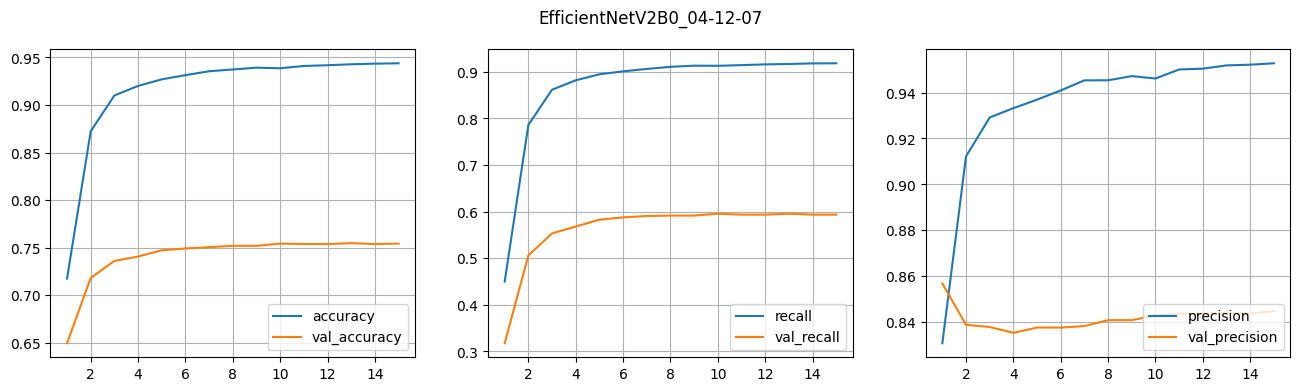

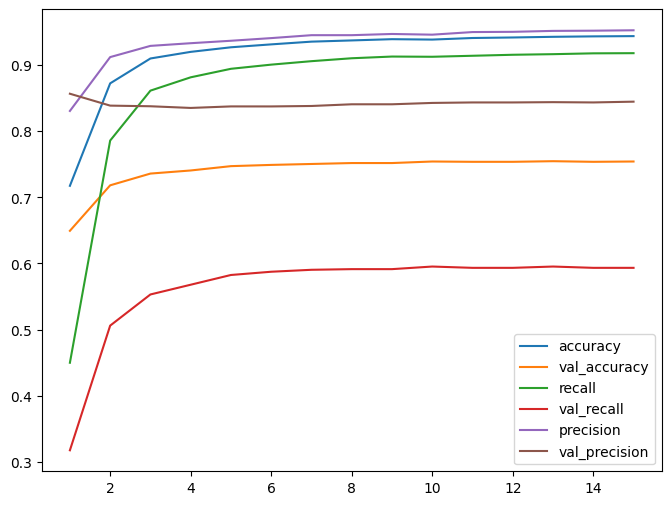

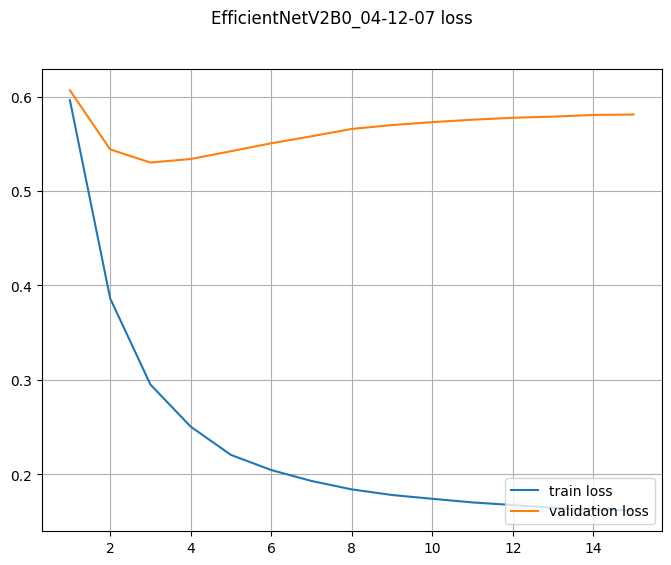

In [ ]:
plot_scores (df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])
plot_loss(df_basic, MODEL_NAME)

### Transfer learning зі зміною моделі (шар 64 нейрони) та зміна параметрів, LEARNING_RATE=5e-5 зі зменшенням при зупинці зниження помилки.

In [ ]:
# модель (Dense шар зменшена кількість нейронів)
inputs = keras.Input(shape=(IM_SIZE, IM_SIZE, 3))
preprocessed = layers.Lambda(preprocess_input)(inputs)
x = base_model(preprocessed, training=False)  #to keep batchnorm layers in inference mode, when unfreeze the base model for fine-tuning
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu', name="full_con1")(x)
outputs = keras.layers.Dense(1, activation='sigmoid', name="pred")(x)
model = keras.Model(inputs, outputs)

In [ ]:
labels = ['tl-', 'ft-']
label = labels[0]
print(label, MODEL_NAME)

LEARNING_RATE=5e-5
# створення та компіляція transfer learning моделі
tl_model = make_model(metrics=METRICS, learning_rate=LEARNING_RATE, model=model, output_bias=initial_bias)
model.summary(show_trainable=True)

tl- EfficientNetV2B0_04-12-07


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lambda_1 (Lambda)           │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 8, 8, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ full_con1 (Dense)           │ (None, 64)            │     81,984 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pred (Dense)                │ (None, 1)             │         65 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 6,001,361 (22.89 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=5),
                  ReduceLROnPlateau(factor=0.7, patience=4, min_lr=1e-6),
                  ModelCheckpoint(f'{label}{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  metrics_logger,
                  # WandbMetricsLogger(),
                  # WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=20

In [ ]:
# EfficientNetV2B0
history = tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/20
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 153s 67ms/step - accuracy: 0.8810 - auc: 0.9417 - fn: 1546.4479 - fp: 939.1946 - loss: 0.2941 - prc: 0.9378 - precision: 0.8882 - recall: 0.8327 - tn: 14602.4648 - tp: 10751.7314 - val_accuracy: 0.7711 - val_auc: 0.8810 - val_fn: 378.0000 - val_fp: 111.0000 - val_loss: 0.6548 - val_prc: 0.8306 - val_precision: 0.8522 - val_recall: 0.6287 - val_tn: 1007.0000 - val_tp: 640.0000 - learning_rate: 5.0000e-05
Epoch 2/20
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.9531 - auc: 0.9867 - fn: 824.5268 - fp: 464.0558 - loss: 0.1331 - prc: 0.9875 - precision: 0.9603 - recall: 0.9325 - tn: 15057.4482 - tp: 11461.9414 - val_accuracy: 0.7921 - val_auc: 0.8894 - val_fn: 334.0000 - val_fp: 110.0000 - val_loss: 0.6427 - val_prc: 0.8186 - val_precision: 0.8615 - val_recall: 0.6719 - val_tn: 1008.0000 - val_tp: 684.0000 - learning_rate: 5.0000e-05
Epoch 3/20
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 145s 50ms/step - accuracy: 0.9590 - auc: 0.9893 - fn: 724.9752

In [ ]:
tl_model.save('/content/tl-EfficientNetV2B0_04-12-07.keras')

In [ ]:
from google.colab import files

df_basic = pd.DataFrame(history.history)
df_basic.to_csv(f"metrics_{label}{MODEL_NAME}.csv", index=False)

files.download(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')
files.download(f'/content/{label}{MODEL_NAME}.keras')
files.download(f'/content/metrics_{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

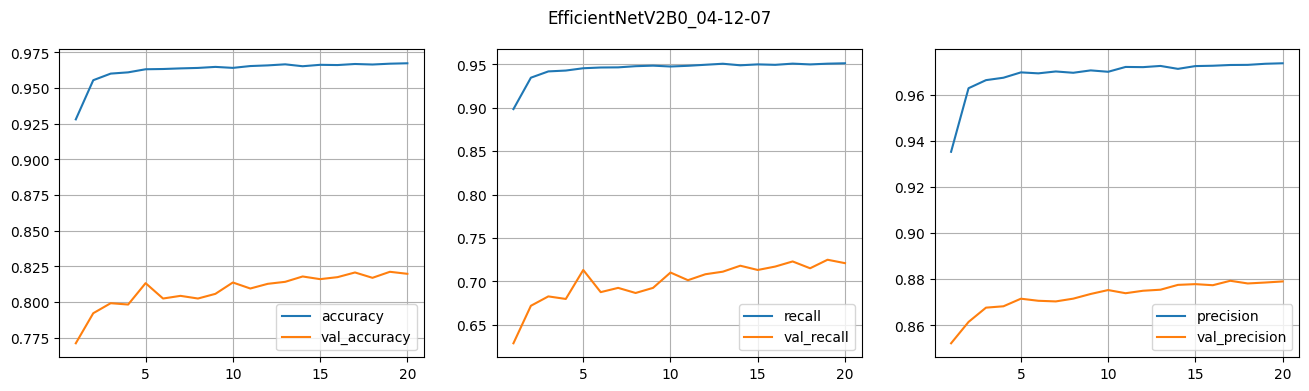

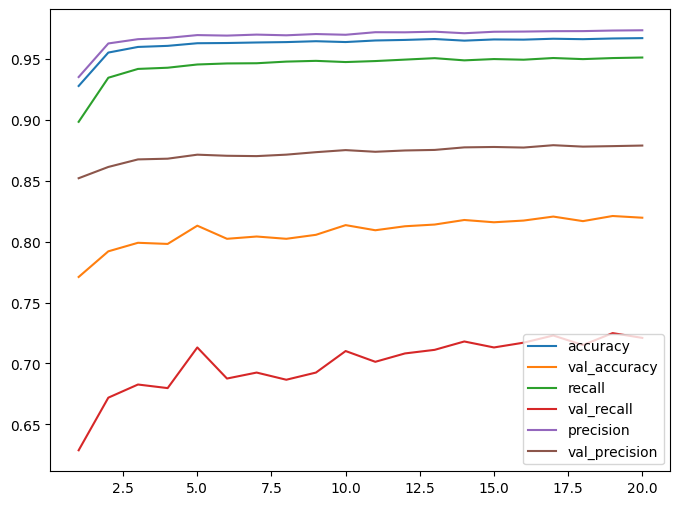

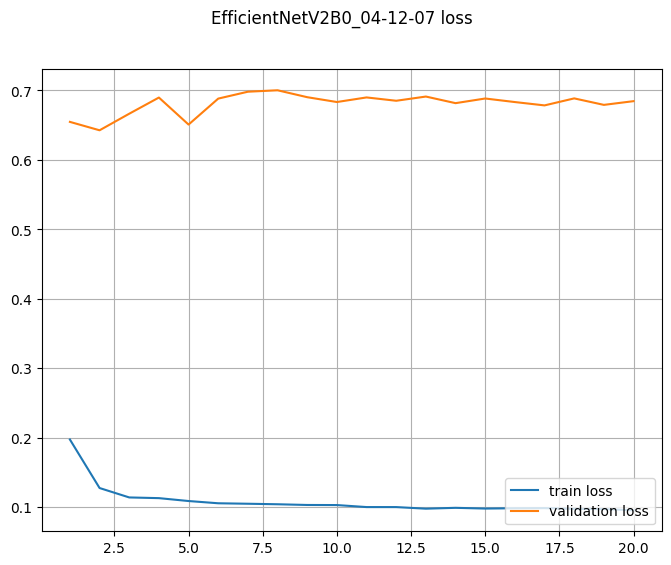

In [ ]:
plot_scores (df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])
plot_loss(df_basic, MODEL_NAME)

In [ ]:
model_path = f"/content/tl-{MODEL_NAME}.keras"
best_tl_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

best_tl_results = best_tl_model.evaluate(test_ds, verbose=1)

precision = best_tl_results[2]
recall = best_tl_results[3]
fbeta = fbeta_metric(precision, recall)
best_tl_results.append(fbeta)

383/383 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9630 - auc: 0.9683 - fn: 200.7969 - fp: 35.8490 - loss: 0.1142 - prc: 0.9052 - precision: 0.9400 - recall: 0.7550 - tn: 5333.3384 - tp: 589.7708


In [ ]:
for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_tl_results):
  print(metric, ': ', value)
print()

loss :  0.1181836873292923
accuracy :  0.9607362151145935
precision :  0.9417397975921631
recall :  0.7435413002967834
tp :  1180.0
fp :  73.0
tn :  10565.0
fn :  407.0
auc :  0.9675085544586182
prc :  0.9054832458496094
f1_beta :  0.7762136763891611



In [ ]:
# Зберегти результат оцінки на тествому наборі
df_eval = pd.DataFrame({'Metric': ["loss"] + [m.name for m in METRICS] + ["f1_beta"], 'Value': best_tl_results})
df_eval.to_csv(f'evaluate_results_{label}{MODEL_NAME}.csv', index=False)
files.download(f'/content/evaluate_results_{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Змінено моніторінг на recall. Збільшено швидкість навчання.

In [ ]:
# модель (Dense шар зменшена кількість нейронів)
inputs = keras.Input(shape=(IM_SIZE, IM_SIZE, 3))
preprocessed = layers.Lambda(preprocess_input)(inputs)
x = base_model(preprocessed, training=False)  #to keep batchnorm layers in inference mode, when unfreeze the base model for fine-tuning
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu', name="full_con1")(x)
outputs = keras.layers.Dense(1, activation='sigmoid', name="pred")(x)
model = keras.Model(inputs, outputs)

In [ ]:
labels = ['tl-', 'ft-']
label = labels[0]
print(label, MODEL_NAME)

LEARNING_RATE=1e-4
# створення та компіляція transfer learning моделі
tl_model = make_model(metrics=METRICS, learning_rate=LEARNING_RATE, model=model, output_bias=initial_bias)
model.summary(show_trainable=True)

tl- EfficientNetV2B0_04-12-10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lambda (Lambda)             │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 8, 8, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ full_con1 (Dense)           │ (None, 64)            │     81,984 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pred (Dense)                │ (None, 1)             │         65 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 6,001,361 (22.89 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=5),
                  ReduceLROnPlateau(factor=0.8, patience=5, min_lr=1e-5),
                  ModelCheckpoint(f'{label}{MODEL_NAME}.keras', monitor='val_recall', save_best_only=True),
                  metrics_logger,
                  # WandbMetricsLogger(),
                  # WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=25

In [ ]:
# EfficientNetV2B0
history = tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/25
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 135s 59ms/step - accuracy: 0.9125 - auc: 0.9659 - fn: 1024.8112 - fp: 836.9211 - loss: 0.2241 - prc: 0.9650 - precision: 0.9036 - recall: 0.9101 - tn: 14681.3887 - tp: 11264.6807 - val_accuracy: 0.7795 - val_auc: 0.8894 - val_fn: 366.0000 - val_fp: 105.0000 - val_loss: 0.6773 - val_prc: 0.8258 - val_precision: 0.8613 - val_recall: 0.6405 - val_tn: 1013.0000 - val_tp: 652.0000 - learning_rate: 1.0000e-04
Epoch 2/25
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.9577 - auc: 0.9890 - fn: 743.0374 - fp: 413.7576 - loss: 0.1182 - prc: 0.9897 - precision: 0.9653 - recall: 0.9383 - tn: 15110.5068 - tp: 11540.6572 - val_accuracy: 0.7963 - val_auc: 0.8923 - val_fn: 332.0000 - val_fp: 103.0000 - val_loss: 0.6914 - val_prc: 0.8146 - val_precision: 0.8695 - val_recall: 0.6739 - val_tn: 1015.0000 - val_tp: 686.0000 - learning_rate: 1.0000e-04
Epoch 3/25
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.9624 - auc: 0.9905 - fn: 675.5354 

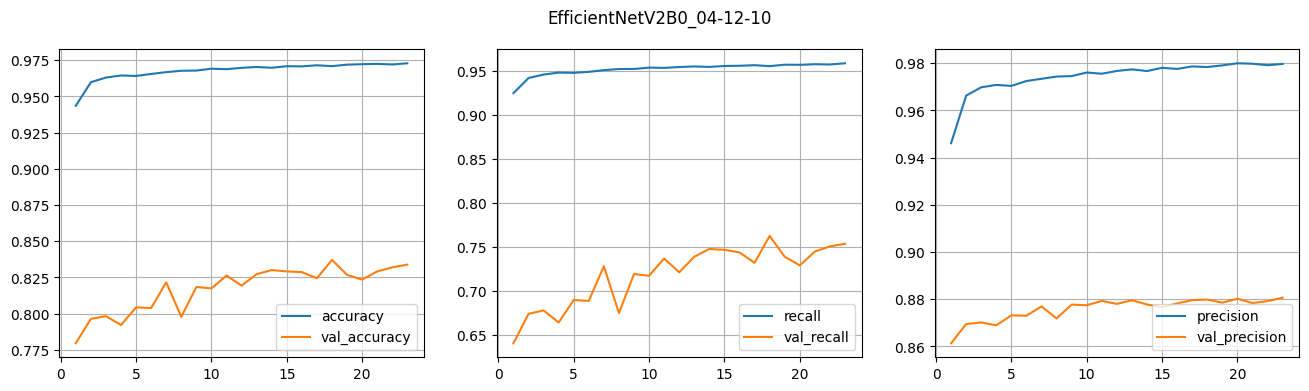

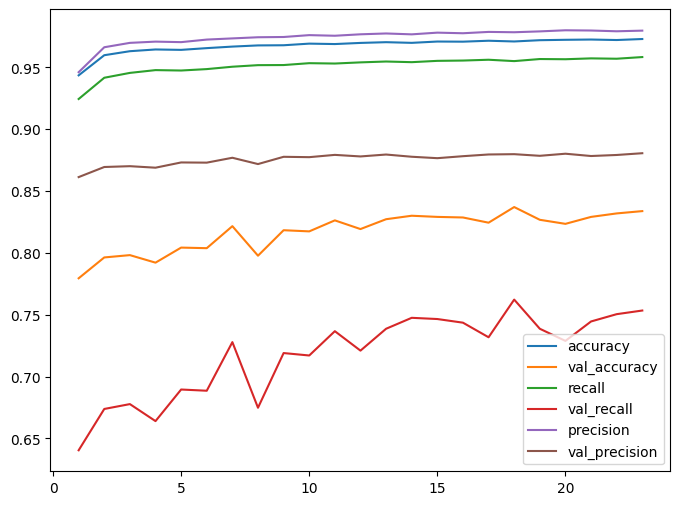

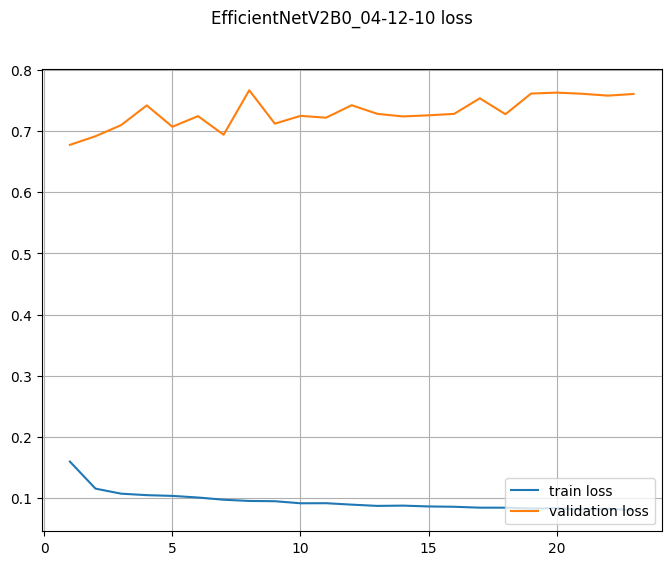

In [ ]:
from google.colab import files

df_basic = pd.DataFrame(history.history)
df_basic.to_csv(f"metrics_{label}{MODEL_NAME}.csv", index=False)

# files.download(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')
# files.download(f'/content/{label}{MODEL_NAME}.keras')
# files.download(f'/content/metrics_{label}{MODEL_NAME}.csv')

plot_scores (df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])
plot_loss(df_basic, MODEL_NAME)

In [ ]:
model_path = f"/content/tl-{MODEL_NAME}.keras"
best_tl_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

best_tl_results = best_tl_model.evaluate(test_ds, verbose=1)

precision = best_tl_results[2]
recall = best_tl_results[3]
fbeta = fbeta_metric(precision, recall)
best_tl_results.append(fbeta)

for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_tl_results):
  print(metric, ': ', value)
print()

383/383 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9502 - auc: 0.9585 - fn: 248.5417 - fp: 59.0234 - loss: 0.1394 - prc: 0.8689 - precision: 0.8924 - recall: 0.6873 - tn: 5310.1641 - tp: 542.0261
loss :  0.14336001873016357
accuracy :  0.9503476619720459
precision :  0.9063017964363098
recall :  0.6887208819389343
tp :  1093.0
fp :  113.0
tn :  10525.0
fn :  494.0
auc :  0.9558069705963135
prc :  0.8712079524993896
f1_beta :  0.7234577892249561



Результат повноти гірший, ніж при transfer learning на вибірці. Збільшення кількості даних та аугментації не покращило вилучення ознак. Для fine tuning краще використати передначану на вибірці модель як feature extractor.